In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os, sys
sys.path.insert(0, "/home/storage/hans/jax_reco_new")

import matplotlib.pyplot as plt
from lib.plotting import adjust_plot_1d

In [2]:
bp = '/home/storage/hans/jax_reco_new/examples/check_seed/small_network/'

In [3]:
data = np.load(bp+'reco_result_21217_21220_sigma_3.0_clipcharge200_c_multi_gamma_mpe_prob_midpoint2_v_AND_weighted_noise_splineMPEseed_multiple.npy')

In [4]:
def GreatCircleDistance(azi_1, zen_1, azi_2, zen_2):
        ra_1 = azi_1
        ra_2 = azi_2
        dec_1 = np.pi/2.0 - zen_1
        dec_2 = np.pi/2.0 - zen_2
        '''Compute the great circle distance between two events'''
        '''All coordinates must be given in radians'''
        delta_dec = np.abs(dec_1 - dec_2)
        delta_ra = np.abs(ra_1 - ra_2)
        x = (np.sin(delta_dec / 2.))**2. + np.cos(dec_1) *\
            np.cos(dec_2) * (np.sin(delta_ra / 2.))**2.
        return 2. * np.arcsin(np.sqrt(x))

In [5]:
def get_gcd(results, scale=20, result_idx=14):
    reco_zenith, reco_azimuth = results[:, result_idx]/scale, results[:, result_idx+1]/scale
    track_src_v = results[:, 2:4]
    true_zenith, true_azimuth = track_src_v[:, 0], track_src_v[:, 1]
    smpe_zenith, smpe_azimuth = results[:, 8], results[:, 9]
    gcd = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, reco_azimuth, reco_zenith))
    gcd_smpe = np.rad2deg(GreatCircleDistance(true_azimuth, true_zenith, smpe_azimuth, smpe_zenith))
    muon_energy = results[:, 0]
    return gcd, gcd_smpe, muon_energy

In [6]:
def get_resolution(results, scale=20, result_idx=14):
    gcd, gcd_smpe, muon_energy = get_gcd(results, scale=scale, result_idx=result_idx)
       
    def get_quantiles(dpsi, energy, e_bins):
        lower, med, upper = [], [], []
        for el, eh in zip(e_bins[:-1], e_bins[1:]):
            #print(el, eh)
            idx = np.logical_and(energy >= el, energy < eh)
            l, m, u = np.percentile(dpsi[idx], [20, 50, 80])
            lower.append(l)
            med.append(m)
            upper.append(u)
        
        return lower, med, upper

    e_nu_range = [2.0, 6.0]
    e_nu_bins = np.linspace(*e_nu_range, 21)
    centers = lambda x: 0.5 * (x[:-1]+x[1:])
    e_nu_centers = centers(e_nu_bins)
    lower, med, upper = get_quantiles(gcd, np.log10(muon_energy), e_nu_bins)
    lower2, med2, upper2 = get_quantiles(gcd_smpe, np.log10(muon_energy), e_nu_bins)

    return (lower, med, upper), (lower2, med2, upper2), e_nu_centers

In [7]:
seed_true, r_smpe, xvals = get_resolution(data, scale=100)
seed_smpe, _, _  = get_resolution(data, scale=100, result_idx=20)

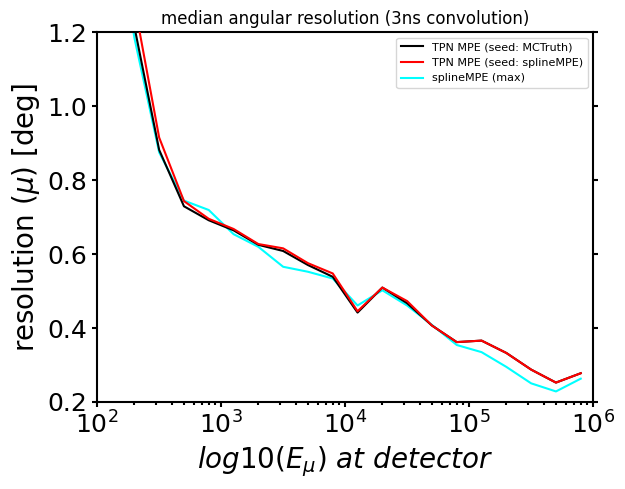

In [8]:
fig, ax = plt.subplots()
plot_args = {'xlabel':'$log10(E_{\\mu})\,\,at\,\,detector$', 
                 'ylabel':'resolution ($\mu$) [deg]', 
                 'xlim':[10**2.0, 10**6.0], 
                 'ylim':[0.2, 1.2]}


ax.plot(10**xvals, seed_true[1], color='black', label='TPN MPE (seed: MCTruth)', linestyle='solid', zorder=17)
ax.plot(10**xvals, seed_smpe[1], color='red', label='TPN MPE (seed: splineMPE)', linestyle='solid', zorder=17)
ax.plot(10**xvals, r_smpe[1], color='cyan', label='splineMPE (max)')
#ax.plot(10**xvals, r_smpe[2], color='cyan', linestyle='dotted')
adjust_plot_1d(fig, ax, plot_args=plot_args)
plt.xscale('log')
plt.title('median angular resolution (3ns convolution)')
ax.set_yticks([0.2*i for i in range(9)][1:-2])
plt.legend(fontsize=8, loc='upper right')
plt.show()

In [9]:
seed_true, smpe, _ = get_gcd(data, scale=100)
seed_smpe, smpe, _  = get_gcd(data, scale=100, result_idx=20)

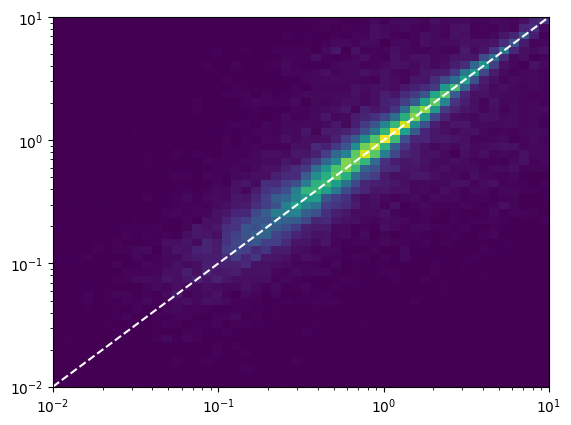

In [10]:
bins = np.logspace(-2, 1, 51)
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist2d(smpe, seed_true, bins=[bins, bins])
ax.set_xlim([0.01, 10])
ax.set_ylim([0.01, 10])
ax.set_yscale('log')
ax.set_xscale('log')
plt.plot([0.01, 10], [0.01, 10], 'w--')
plt.show()

In [42]:
widths = np.diff(bins)

hist_joint, _ = np.histogramdd([smpe, seed_true], bins=[bins, bins], density=True)
# to generate the marginal pdf, we integrate / marginalize the joint pdf over the psi dimension.
# since we only have a "binned" representation (a piecewise constant function), the integration is approximated by \sum f(E,Psi) * \Delta\Psi
hist_marginal = np.sum(hist_joint, axis=1, keepdims=True) * widths

# the conditional pdf then follows through division
hist_cond = hist_joint / hist_marginal

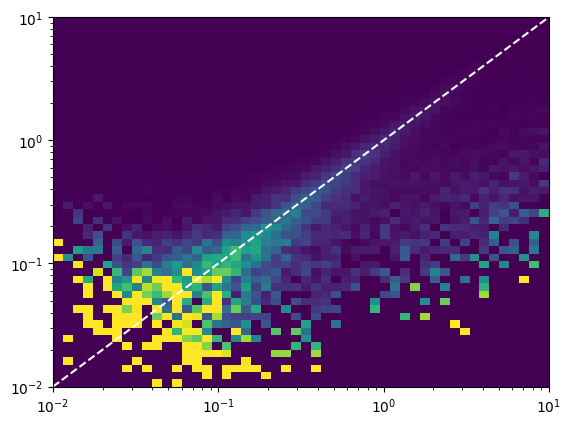

In [44]:
import matplotlib

fig, ax = plt.subplots()
X, Y = np.meshgrid(bins, bins)

pc = ax.pcolormesh(X, Y, hist_cond.T, norm=matplotlib.colors.Normalize(vmin=0.0, vmax=10.0))

ax.set_xlim([0.01, 10])
ax.set_ylim([0.01, 10])
ax.set_yscale('log')
ax.set_xscale('log')
plt.plot([0.01, 10], [0.01, 10], 'w--')

plt.show()

In [45]:
widths = np.diff(bins)

hist_joint, _ = np.histogramdd([smpe, seed_true], bins=[bins, bins], density=True)
# to generate the marginal pdf, we integrate / marginalize the joint pdf over the psi dimension.
# since we only have a "binned" representation (a piecewise constant function), the integration is approximated by \sum f(E,Psi) * \Delta\Psi
hist_marginal = np.sum(hist_joint, axis=0, keepdims=True) * widths

# the conditional pdf then follows through division
hist_cond = hist_joint / hist_marginal

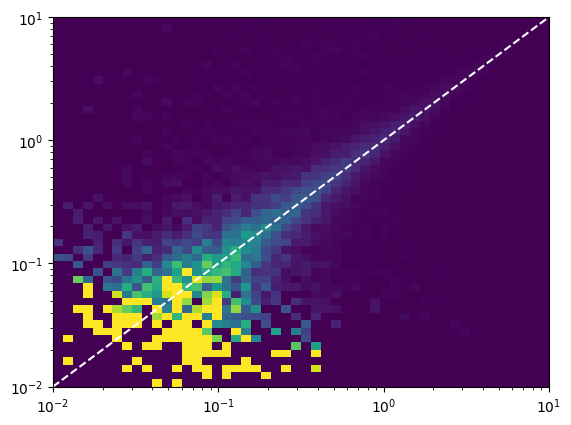

In [46]:
import matplotlib

fig, ax = plt.subplots()
X, Y = np.meshgrid(bins, bins)

pc = ax.pcolormesh(X, Y, hist_cond.T, norm=matplotlib.colors.Normalize(vmin=0.0, vmax=10.0))

ax.set_xlim([0.01, 10])
ax.set_ylim([0.01, 10])
ax.set_yscale('log')
ax.set_xscale('log')
plt.plot([0.01, 10], [0.01, 10], 'w--')

plt.show()

In [14]:
np.max(smpe)

138.65638004991868

In [20]:
print(np.log10(smpe))

[ 0.76609961 -0.86524746 -0.4819851  ...  0.40247757 -0.52028776
  0.25796311]


In [22]:
bins

array([ 0.01      ,  0.01072267,  0.01149757,  0.01232847,  0.01321941,
        0.01417474,  0.01519911,  0.01629751,  0.01747528,  0.01873817,
        0.02009233,  0.02154435,  0.0231013 ,  0.02477076,  0.02656088,
        0.02848036,  0.03053856,  0.03274549,  0.03511192,  0.03764936,
        0.04037017,  0.04328761,  0.04641589,  0.04977024,  0.05336699,
        0.05722368,  0.06135907,  0.06579332,  0.07054802,  0.07564633,
        0.08111308,  0.0869749 ,  0.09326033,  0.1       ,  0.10722672,
        0.1149757 ,  0.12328467,  0.13219411,  0.14174742,  0.15199111,
        0.16297508,  0.17475284,  0.18738174,  0.2009233 ,  0.21544347,
        0.23101297,  0.24770764,  0.26560878,  0.28480359,  0.30538555,
        0.32745492,  0.35111917,  0.37649358,  0.40370173,  0.43287613,
        0.46415888,  0.49770236,  0.53366992,  0.57223677,  0.61359073,
        0.65793322,  0.70548023,  0.75646333,  0.81113083,  0.869749  ,
        0.93260335,  1.        ,  1.07226722,  1.149757  ,  1.23